# 2D Multi-element Airfoil

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate
%matplotlib inline

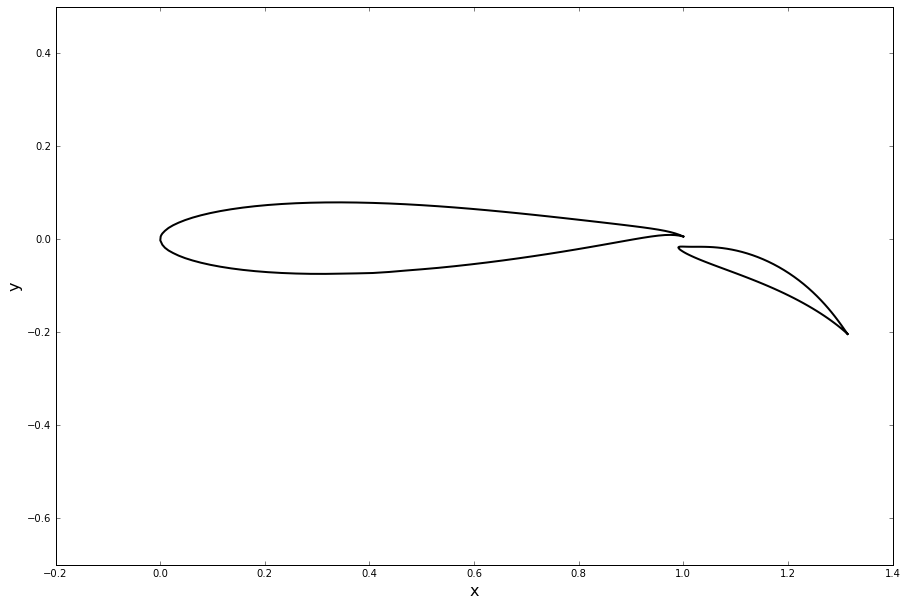

In [2]:
# load geometry for each
MainFoil = np.genfromtxt('../AeroPython/lessons/resources/MainFoil_N=100.csv', delimiter=',')
FlapFoil = np.genfromtxt('../AeroPython/lessons/resources/FlapFoil_N=100.csv', delimiter=',')

# define x and y for each
x_foil, y_foil = MainFoil[:,0], MainFoil[:,1]
x_flap, y_flap = FlapFoil[:,0], FlapFoil[:,1]

# plot geometry
width = 10
plt.figure(figsize=(15, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_foil, y_foil, linewidth=2, linestyle='-', color='k')
plt.plot(x_flap, y_flap, linewidth=2, linestyle='-', color='k')
plt.xlim(-0.2, 1.4)
plt.ylim(-0.7, 0.5)
plt.axis(adjustabel='box');

In [3]:
# create panel class
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point
        ya: float
            y-coordinate of the first end-point
        xb: float
            x-coordinate of the second end-point
        yb: float
            y-coordinate of the second end-point
        """
        self.xa, self.ya = xa, ya     # panel starting point
        self.xb, self.yb = xb, yb     # panel end point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)  # panel length
        
        # orientation of the panel
        if xb-xa <= 0.0:
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = math.pi + np.arccos(-(yb-ya)/self.length)
            
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper'    # upper surface
        else:
            self.loc = 'lower'    # lower surface
        
        self.sigma = 0.0     # source strength
        self.vt = 0.0        # tangential velocity
        self.cp = 0.0        # coefficient of pressure

In [4]:
# define panels for main foil
def define_panels_foil(x, y, N=100):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D numpy array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 50
        
    Returns
    -------
    panels: 1D numpy array of Panel objects
        The list of panels.
    """
    x_ends = x_foil                         # x-coordinate of the panels end-points
    y_ends = y_foil                # y-coordinate of the panels end-points
    
    # create panels
    panels = np.empty(N, dtype = object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

In [5]:
# define panels for flap
def define_panels_flap(x, y, N=100):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D numpy array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 50
        
    Returns
    -------
    panels: 1D numpy array of Panel objects
        The list of panels.
    """
    x_ends = x_flap                     # x-coordinate of the panels end-points
    y_ends = y_flap                     # y-coordinate of the panels end-points
    
    # create panels
    panels = np.empty(N, dtype = object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

In [6]:
# discretize geometry into panels
panels_foil = define_panels_foil(x_foil, y_foil, N=100)
panels_flap = define_panels_flap(x_flap, y_flap, N=100)

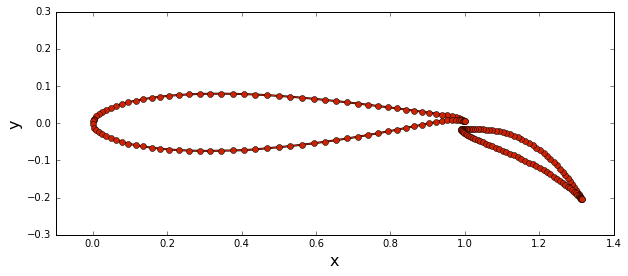

In [7]:
# plot discretized geometry
width = 10
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_foil, y_foil, color='k', linewidth=2, linestyle='-')
plt.plot(x_flap, y_flap, color='k', linewidth=2, linestyle='-')
plt.plot(np.append([panel.xa for panel in panels_foil], panels_foil[0].xa),
            np.append([panel.ya for panel in panels_foil], panels_foil[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.plot(np.append([panel.xa for panel in panels_flap], panels_flap[0].xa),
            np.append([panel.ya for panel in panels_flap], panels_flap[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.3, 0.3);

## Freestream Conditions

In [8]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees)
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*np.pi/180.0

In [9]:
# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha=4.0)

## Build Matrices

In [10]:
# define integral for the source and vortex contributions (can use for both main foil and flap)
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - np.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + np.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - np.sin(panel.beta)*s))**2
                   +(y - (panel.ya + np.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [11]:
# source contribution for main foil and flap
def source_contribution_normal(panels_foil, panels_flap):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    Total_Panels = np.append(panels_foil, panels_flap)
    A = np.empty((len(Total_Panels),len(Total_Panels)), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(Total_Panels):
        for j, panel_j in enumerate(Total_Panels):
            if i != j:
                A[i, j] = 0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                np.cos(panel_i.beta),
                                                np.sin(panel_i.beta))
    return A

In [12]:
# define vortex contribution for main foil and flap
def vortex_contribution_normal(panels_foil, panels_flap):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    Total_Panels = np.append(panels_foil, panels_flap)
    A = np.empty((len(Total_Panels),len(Total_Panels)), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(Total_Panels):
        for j, panel_j in enumerate(Total_Panels):
            if i != j:
                A[i, j] = -0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.sin(panel_i.beta),
                                                 -np.cos(panel_i.beta))
    return A

In [13]:
# create source and vortex matrices
A_source = source_contribution_normal(panels_foil, panels_flap)
B_vortex = vortex_contribution_normal(panels_foil, panels_flap)

In [34]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = np.empty((2, A_source.shape[0]+2), dtype=float)
    print(b.shape)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[0, :-2] = B_vortex[0, :] + B_vortex[99, :]
    b[1, :-2] = B_vortex[100, :] + B_vortex[-1, :]
#     b[:-2] = B_vortex[0, :] + B_vortex[199, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[0, -2] = - np.sum(A_source[0, :] + A_source[99, :])
    b[0, -1] = - np.sum(A_source[100, :] + A_source[199, :])
    b[1, -2] = - np.sum(A_source[0, :] + A_source[99, :])
    b[1, -1] = - np.sum(A_source[100, :] + A_source[199, :])
    
    return b

In [35]:
b = kutta_condition(A_source, B_vortex)
print(b)

(2, 202)
[[ -5.33516243e-02  -2.06407527e-02  -2.87166991e-03  -8.62324571e-04
   -4.76183075e-05   3.94776213e-04   6.52099294e-04   7.98830519e-04
    8.74193550e-04   9.03068585e-04   9.02648322e-04   8.84211589e-04
    8.55410794e-04   8.21057463e-04   7.84227713e-04   7.46823493e-04
    7.10024726e-04   6.74567348e-04   6.40832660e-04   6.08956054e-04
    5.78922967e-04   5.50653812e-04   5.24084449e-04   4.99112566e-04
    4.75574369e-04   4.53315553e-04   4.32199343e-04   4.12090218e-04
    3.92850778e-04   3.74349617e-04   3.56479020e-04   3.39138433e-04
    3.22223012e-04   3.05642151e-04   2.89312536e-04   2.73153277e-04
    2.57111268e-04   2.41125569e-04   2.25126480e-04   2.09113772e-04
    1.93050401e-04   1.76856071e-04   1.60733494e-04   1.44700238e-04
    1.28035583e-04   1.12493010e-04   9.95175985e-05   8.24479261e-05
    4.17119180e-05   3.87942819e-05   9.15461899e-05   1.17830759e-04
    9.43420592e-05   1.07751560e-04   1.25775673e-04   1.50280673e-04
    1.73771

In [27]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = np.empty((A_source.shape[0]+2, A_source.shape[1]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = np.sum(B_vortex[:, 0:99], axis=1)
    A[:-2, -1] = np.sum(B_vortex[:, 100:199], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    return A

In [36]:
Total_Panels = np.append(panels_foil, panels_flap)

def build_freestream_rhs(Total_Panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(len(Total_Panels)+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(Total_Panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-Total_Panels[100].beta)
                               +np.sin(freestream.alpha-Total_Panels[199].beta) )
    b[-2] = -freestream.u_inf*( np.sin(freestream.alpha-Total_Panels[0].beta)
                               +np.sin(freestream.alpha-Total_Panels[99].beta) )
    return b

In [37]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(Total_Panels, freestream)

(2, 202)


In [39]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(Total_Panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma_foil = strengths[-2]
gamma_flap = strengths[-1]

print(strengths)

[-17.53421853 -11.14267643  -8.40408398  -6.49228481  -5.07755858
  -4.0345008   -3.28766198  -2.77080362  -2.42180198  -2.18713385
  -2.03235582  -1.93054212  -1.86563883  -1.82578133  -1.80326567
  -1.79261425  -1.78963276  -1.79203197  -1.79848077  -1.80806882
  -1.81989255  -1.83229811  -1.84493462  -1.85852204  -1.87255724
  -1.88655365  -1.90075678  -1.91561111  -1.93140169  -1.9473343
  -1.96268089  -1.97805667  -1.99352193  -2.00841754  -2.02301117
  -2.03719485  -2.04928394  -2.05977726  -2.06861112  -2.07108208
  -2.06722696  -2.05702742  -2.02199093  -1.96221126  -1.9104478
  -1.72766535  -1.34610843  -1.13785827  -0.52039368  -0.08705802
   0.96400556   2.59134596   2.82874867   3.03225993   3.1197721
   3.05794547   2.9628247    2.87383605   2.78346808   2.68578606
   2.59118795   2.50133728   2.41407984   2.33084726   2.25191976
   2.17673145   2.10647333   2.04044141   1.97362818   1.91817303
   1.88963201   1.82503371   1.71121518   1.67018068   1.67699896
   1.63850356

In [46]:
def compute_tangential_velocity(Total_Panels, freestream, gamma_foil, gamma_flap, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((len(Total_Panels), len(Total_Panels)+2), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-2] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -2] = -np.sum(A_source[:, 0:99], axis=1)
    A[:, -1] = -np.sum(A_source[:, 100:199], axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in Total_Panels])
    
    strengths = np.append([panel.sigma for panel in Total_Panels], [gamma_foil, gamma_flap])
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(Total_Panels):
        panel.vt = tangential_velocities[i]

In [47]:
# tangential velocity at each panel center.
compute_tangential_velocity(Total_Panels, freestream, gamma_foil, gamma_flap, A_source, B_vortex)

In [48]:
print(gamma_foil)
print(gamma_flap)

0.758815061166
0.611398365194


In [49]:
def compute_pressure_coefficient(Total_Panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in Total_Panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [50]:
# surface pressure coefficient
compute_pressure_coefficient(Total_Panels, freestream)

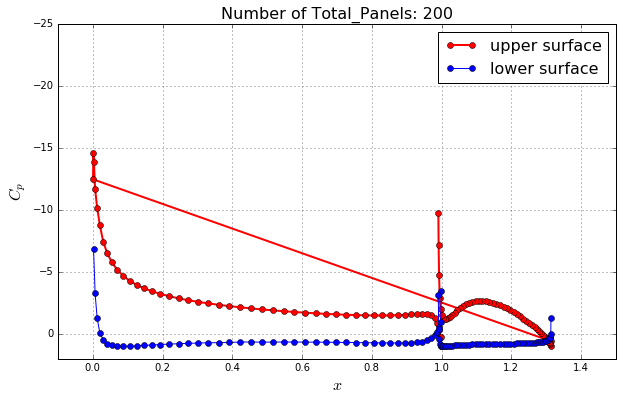

In [51]:
# plot surface pressure coefficient
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in Total_Panels if panel.loc == 'upper'],
            [panel.cp for panel in Total_Panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
plt.plot([panel.xc for panel in Total_Panels if panel.loc == 'lower'],
            [panel.cp for panel in Total_Panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.5)
plt.ylim(2.0, -25.0)
plt.title('Number of Total_Panels: {}'.format(Total_Panels.size), fontsize=16);

# Part 2 - Wenzinger's Test Case

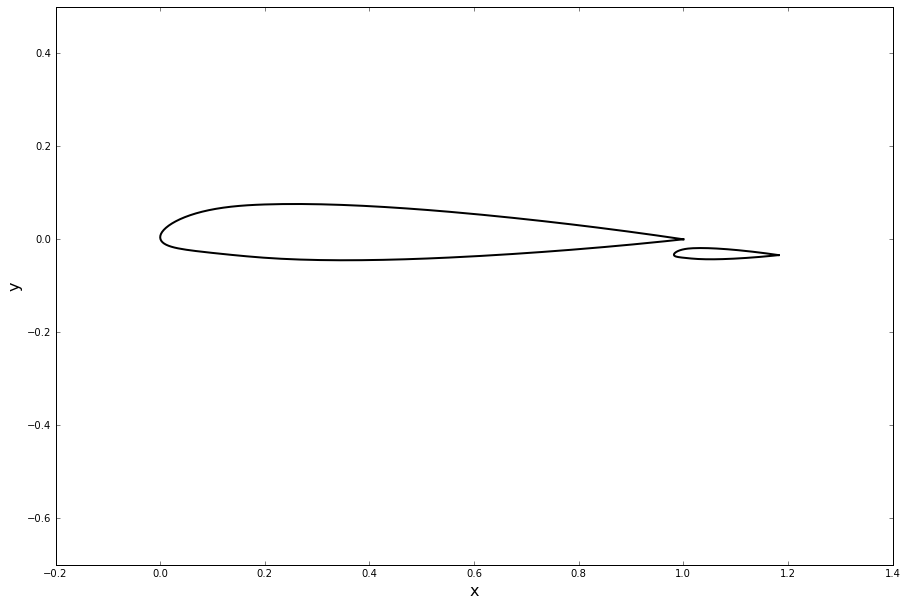

In [52]:
# load geometry for each
MainFoil = np.genfromtxt('../AeroPython/lessons/resources/NACA23012_MainFoil.csv', delimiter=',')
FlapFoil = np.genfromtxt('../AeroPython/lessons/resources/NACA23012_FlapFoil.csv', delimiter=',')

# define x and y for each
x_foil, y_foil = MainFoil[:,0], MainFoil[:,1]
x_flap, y_flap = FlapFoil[:,0], FlapFoil[:,1]

# plot geometry
width = 10
plt.figure(figsize=(15, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_foil, y_foil, linewidth=2, linestyle='-', color='k')
plt.plot(x_flap, y_flap, linewidth=2, linestyle='-', color='k')
plt.xlim(-0.2, 1.4)
plt.ylim(-0.7, 0.5)
plt.axis(adjustabel='box');

In [53]:
# define rotation function to rotate flap
def rotate(hinge, array, angle):
    """
    Rotate the flap about the hinge point (1.03, -0.054)
    
    Parameters
    ----------
    hinge: x, y coordinates
        rotation point
    array: 2D array of x, y coordinates of flap
        flap coordinates
    angle: float
        angle of rotation in degrees
        
    Returns
    -------
    new_x: 1D numpy array
        new x-coordinate array after rotation
    new_y: 1D numpy array
        new y-coordinate array after rotation
    """
    hx, hy = hinge
    array_x, array_y = array

    new_x = hx + math.cos(angle) * (array_x - hx) - math.sin(angle) * (array_y - hy)
    new_y = hy + math.sin(angle) * (array_x - hx) + math.cos(angle) * (array_y - hy)
    return new_x, new_y

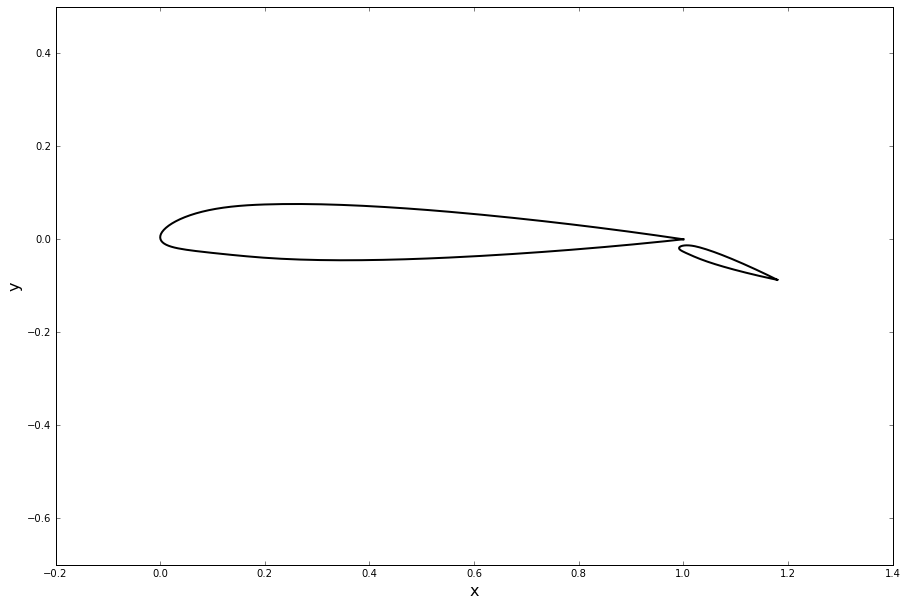

In [54]:
# define rotated flap
x_foil, y_foil = MainFoil[:,0], MainFoil[:,1]
x_flap, y_flap = rotate((1.03,-.054),(FlapFoil[:,0], FlapFoil[:,1]),-20*np.pi/180)

# plot geometry
width = 10
plt.figure(figsize=(15, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_foil, y_foil, linewidth=2, linestyle='-', color='k')
plt.plot(x_flap, y_flap, linewidth=2, linestyle='-', color='k')
plt.xlim(-0.2, 1.4)
plt.ylim(-0.7, 0.5)
plt.axis(adjustabel='box');

In [55]:
# create panel class
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point
        ya: float
            y-coordinate of the first end-point
        xb: float
            x-coordinate of the second end-point
        yb: float
            y-coordinate of the second end-point
        """
        self.xa, self.ya = xa, ya     # panel starting point
        self.xb, self.yb = xb, yb     # panel end point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)  # panel length
        
        # orientation of the panel
        if xb-xa <= 0.0:
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = math.pi + np.arccos(-(yb-ya)/self.length)
            
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper'    # upper surface
        else:
            self.loc = 'lower'    # lower surface
        
        self.sigma = 0.0     # source strength
        self.vt = 0.0        # tangential velocity
        self.cp = 0.0        # coefficient of pressure

In [56]:
# define panels for main foil
def define_panels_foil(x, y, N=150):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D numpy array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 50
        
    Returns
    -------
    panels: 1D numpy array of Panel objects
        The list of panels.
    """
    x_ends = x_foil                         # x-coordinate of the panels end-points
    y_ends = y_foil                # y-coordinate of the panels end-points
    
    # create panels
    panels = np.empty(N, dtype = object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

In [57]:
# define panels for flap
def define_panels_flap(x, y, N=150):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D numpy array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 50
        
    Returns
    -------
    panels: 1D numpy array of Panel objects
        The list of panels.
    """
    x_ends = x_flap                     # x-coordinate of the panels end-points
    y_ends = y_flap                     # y-coordinate of the panels end-points
    
    # create panels
    panels = np.empty(N, dtype = object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

In [58]:
# discretize geometry into panels
panels_foil = define_panels_foil(x_foil, y_foil, N=150)
panels_flap = define_panels_flap(x_flap, y_flap, N=150)

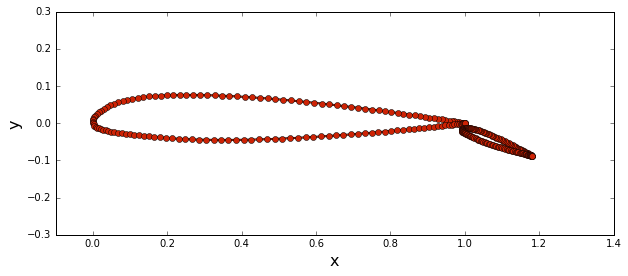

In [59]:
# plot discretized geometry
width = 10
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_foil, y_foil, color='k', linewidth=2, linestyle='-')
plt.plot(x_flap, y_flap, color='k', linewidth=2, linestyle='-')
plt.plot(np.append([panel.xa for panel in panels_foil], panels_foil[0].xa),
            np.append([panel.ya for panel in panels_foil], panels_foil[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.plot(np.append([panel.xa for panel in panels_flap], panels_flap[0].xa),
            np.append([panel.ya for panel in panels_flap], panels_flap[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.3, 0.3);

In [60]:
# source contribution for main foil and flap
def source_contribution_normal(panels_foil, panels_flap):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    Total_Panels = np.append(panels_foil, panels_flap)
    A = np.empty((len(Total_Panels),len(Total_Panels)), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(Total_Panels):
        for j, panel_j in enumerate(Total_Panels):
            if i != j:
                A[i, j] = 0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                np.cos(panel_i.beta),
                                                np.sin(panel_i.beta))
    return A

In [61]:
# define vortex contribution for main foil and flap
def vortex_contribution_normal(panels_foil, panels_flap):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    Total_Panels = np.append(panels_foil, panels_flap)
    A = np.empty((len(Total_Panels),len(Total_Panels)), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(Total_Panels):
        for j, panel_j in enumerate(Total_Panels):
            if i != j:
                A[i, j] = -0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.sin(panel_i.beta),
                                                 -np.cos(panel_i.beta))
    return A

In [62]:
A_source = source_contribution_normal(panels_foil, panels_flap)
B_vortex = vortex_contribution_normal(panels_foil, panels_flap)

In [63]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = np.empty(A_source.shape[0]+2, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-2] = B_vortex[0, :] + B_vortex[199, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - np.sum(A_source[100, :] + A_source[199, :])
    b[-2] = - np.sum(A_source[0, :] + A_source[99, :])
    return b

In [64]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = np.empty((A_source.shape[0]+2, A_source.shape[1]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = np.sum(B_vortex[:, 0:99], axis=1)
    A[:-2, -1] = np.sum(B_vortex[:, 100:199], axis=1)
    # Kutta condition array
    A[-1:-2, :] = kutta_condition(A_source, B_vortex)
    return A

In [65]:
Total_Panels = np.append(panels_foil, panels_flap)

A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(Total_Panels, freestream)

In [66]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(Total_Panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma_foil = strengths[-2]
gamma_flap = strengths[-1]

In [67]:
def compute_tangential_velocity(Total_Panels, freestream, gamma_foil, gamma_flap, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((len(Total_Panels), len(Total_Panels)+2), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-2] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -2] = -np.sum(A_source[:, 0:99], axis=1)
    A[:, -1] = -np.sum(A_source[:, 100:199], axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in Total_Panels])
    
    strengths = np.append([panel.sigma for panel in Total_Panels], [gamma_foil, gamma_flap])
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(Total_Panels):
        panel.vt = tangential_velocities[i]

In [68]:
# tangential velocity at each panel center.
compute_tangential_velocity(Total_Panels, freestream, gamma_foil, gamma_flap, A_source, B_vortex)

In [69]:
def compute_pressure_coefficient(Total_Panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in Total_Panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [70]:
# surface pressure coefficient
compute_pressure_coefficient(Total_Panels, freestream)

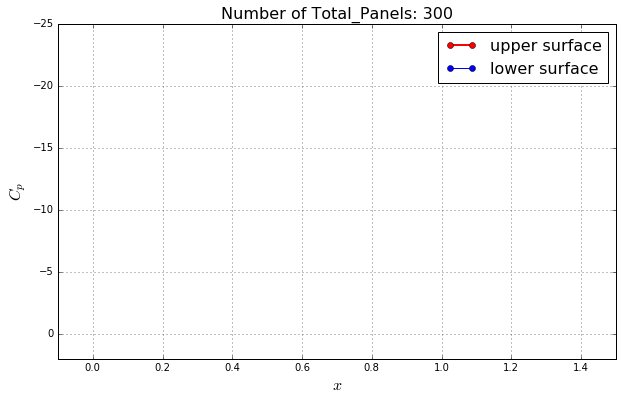

In [71]:
# plot surface pressure coefficient
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in Total_Panels if panel.loc == 'upper'],
            [panel.cp for panel in Total_Panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
plt.plot([panel.xc for panel in Total_Panels if panel.loc == 'lower'],
            [panel.cp for panel in Total_Panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.5)
plt.ylim(2.0, -25.0)
plt.title('Number of Total_Panels: {}'.format(Total_Panels.size), fontsize=16);